# Introduction

This project examines the current state of lecture capture technology within academic institutions. While widely adopted for recording lectures and providing students with review materials, existing systems often fall short of meeting contemporary learning demands. Their basic functionality struggles to keep pace with evolving pedagogical standards, highlighting a critical need for enhancement through artificial intelligence. This project proposes a robust solution aimed at transforming raw lecture content into an intelligent, queryable knowledge base. This advancement would enable users to pose precise questions about lecture material and receive instant, accurate answers, even when information is embedded within spoken discourse or scanned documents, thereby significantly enriching the learning experience and the utility of archived lectures.

# Installing and Importing necessary libraries

In [ ]:
!apt-get update
!apt-get install tesseract-ocr libtesseract-dev -y
!pip install Pillow pytesseract pdf2image -q
!pip install --upgrade pip
!pip install pydub
!pip install PyPDF2
!pip install ffmpeg-python
!pip install --upgrade git+https://github.com/huggingface/transformers.git accelerate datasets[audio]
!pip install langchain_community
!pip install sentence-transformers
!pip install rank_bm25
!pip install transformers accelerate
!pip install faiss-cpu
!sudo apt-get update
!sudo apt-get install poppler-utils

import google.generativeai as genai
import os
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from pydub import AudioSegment
import torch
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import PyPDF2
from PIL import Image
import pytesseract
from pdf2image import convert_from_path

from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from rank_bm25 import BM25Okapi
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import faiss
from IPython.display import display, Markdown

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

# Audio Processing (MP3 to WAV & Transcription)

The workflow begins by converting the input MP3 audio file ('Chicken Cottage 4.mp3') to a WAV format, a necessary step for compatibility and optimal performance with subsequent audio processing tools.

An automatic speech recognition (ASR) pipeline is then implemented using the pre-trained `washeed/audio-transcribe` model from Hugging Face. This pipeline efficiently loads the model, leveraging GPU acceleration if available, processes the converted WAV audio, and generates a comprehensive text transcript.

(Note - For the purpose of this prototype, 'Chicken Cottage 4.mp3' serves as a simulated lecture recording where a financial report is being summarized.)

In [ ]:
mp3_file = "/content/Chicken Cottage 4.mp3"
wav_file = "output.wav"

print(f"Converting {mp3_file} to {wav_file}...")
sound = AudioSegment.from_mp3(mp3_file)
sound.export(wav_file, format="wav")
print("Conversion complete.")

print("Setting up audio transcription pipeline...")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "washeed/audio-transcribe"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    batch_size=16,
    return_timestamps=True,
    torch_dtype=torch_dtype,
    device=device,
)

print(f"Transcribing audio from {mp3_file}...")
result = pipe(mp3_file, generate_kwargs={"task": "transcribe"})
transcript_text = result["text"]
print("\n--- Audio Transcript ---")
print(transcript_text)

Converting /content/Chicken Cottage 4.mp3 to output.wav...
Conversion complete.
Setting up audio transcription pipeline...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Device set to use cuda:0


Transcribing audio from /content/Chicken Cottage 4.mp3...


/usr/local/lib/python3.11/dist-packages/transformers/models/whisper/generation_whisper.py:582: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Audio Transcript ---
 good afternoon everyone today I'll briefly cover Novartek limited solid quarter one of the 2025 financial performance in the first quarter 2025 Novartek achieved a strong 12% year-over-year revenue increase driven by cloud and AI services their revenue reached 42.3 million pounds up to up from 37.7 million pounds gross profit also saw a healthy rise to 25.6 million pounds while net income modestly increased to 6.1 million pounds this reflects our strategic investments in operating expenses and r&d which saw a significant 20 percent jump our cash position also strengthened considerably looking at our segments clouded infrastructure revenue grew by 14.5% to 19.3 million pounds, fueled by Nova Cloud 2.0 adoption. AI and data services saw a 10.1% increase to 14.7 million pounds, with strong traction in retail and healthcare. Enterprise software grew by 9.8% to 8.3 million pounds benefiting from demand for remote work tools all segments maintained healthy gross ma

# PDF Processing (Text Extraction & OCR for Images)

This section outlines a two-pronged approach for comprehensive text extraction from PDF documents, capturing both native text and image-embedded content.

Initial text extraction is performed by the `read_pdf` function using `PyPDF2`, which directly retrieves searchable text from each page and compiles it into a single string. This step includes error handling for common file-related exceptions.

For text embedded within images (e.g., scanned content), the `extract_text_from_images_in_pdf` function is applied. This involves converting PDF pages into images via `pdf2image`'s `convert_from_path` and then employing `pytesseract` for Optical Character Recognition (OCR) to extract text from these visual representations.

The integration of direct text extraction and OCR ensures a complete capture of all textual data from the PDF, preparing the unified document for subsequent processing steps.

(Note - For the purpose of this prototype, 'NovaTech_Q1_2025_Financial_Report.pdf' serves as a simulated lecture content PDF that the lecturer or professor uses to present slides.)

In [ ]:
def read_pdf(pdf_file_path):
  """Reads text from a PDF file."""
  try:
    with open(pdf_file_path, 'rb') as pdf_file:
      pdf_reader = PyPDF2.PdfReader(pdf_file)
      text = ""
      for page_num in range(len(pdf_reader.pages)):
        page = pdf_reader.pages[page_num]
        text += page.extract_text()
      return text
  except FileNotFoundError:
    print(f"Error: File not found at '{pdf_file_path}'")
    return None
  except PyPDF2.errors.PdfReadError:
    print(f"Error: Could not read PDF file '{pdf_file_path}'. It might be corrupted or encrypted.")
    return None
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

def extract_text_from_images_in_pdf(pdf_path):
  """Extracts text from images embedded within a PDF using OCR."""
  try:
    images = convert_from_path(pdf_path)
    ocr_text = ""
    for i, img in enumerate(images):
        print(f"Processing image from page {i+1} for OCR...")
        text = pytesseract.image_to_string(img)
        ocr_text += text + "\n---\n"
    return ocr_text
  except FileNotFoundError:
    print(f"Error: File not found at '{pdf_path}'")
    return None
  except Exception as e:
    print(f"An unexpected error occurred during OCR: {e}")
    return None

pdf_path = "/content/NovaTech_Q1_2025_Financial_Report.pdf"
print(f"\nReading text from PDF: {pdf_path} (direct text extraction)...")
pdf_text = read_pdf(pdf_path)

if pdf_text:
    print("\n--- PDF Direct Text Content (first 500 characters) ---")
    print(pdf_text[:500] + "..." if len(pdf_text) > 500 else pdf_text)
else:
    print("Could not extract direct text content from PDF.")

print(f"\nPerforming OCR on images in PDF: {pdf_path}...")
ocr_content = extract_text_from_images_in_pdf(pdf_path)

if ocr_content:
    print("\n--- Text Extracted from Images (OCR) ---")
    print(ocr_content[:500] + "..." if len(ocr_content) > 500 else ocr_content)
else:
    print("Could not extract text from images using OCR.")

# Combine all textual content for chunking
combined_document_text = (transcript_text if transcript_text else "") + \
                         (pdf_text if pdf_text else "") + \
                         (ocr_content if ocr_content else "")


Reading text from PDF: /content/NovaTech_Q1_2025_Financial_Report.pdf (direct text extraction)...

--- PDF Direct Text Content (first 500 characters) ---
NovaTech Ltd. - Q1 2025 Financial Report
1. Executive Summary
NovaTech Ltd., a mid-sized technology solutions provider, reported solid performance in Q1 2025. Revenue
increased by 12% year-over-year, driven by strong demand in cloud services and enterprise AI integration.
Net profit rose modestly due to increased operating expenses and R&D investments.
2. Key Financial Highlights
Metric Q1 2025 Q1 2024 Change (%)
Revenue £42.3 million £37.7 million +12.2%
Gross Profit £25.6 million £22.8 million...

Performing OCR on images in PDF: /content/NovaTech_Q1_2025_Financial_Report.pdf...
Processing image from page 1 for OCR...
Processing image from page 2 for OCR...

--- Text Extracted from Images (OCR) ---
NovaTech Ltd. - Q1 2025 Financial Report

1. Executive Summary
NovaTech Ltd., a mid-sized technology solutions provider, reported solid

# Text Chunking and Embeddings

This section outlines the critical processes for preparing extracted textual content for efficient semantic search and retrieval, particularly beneficial for large datasets. This preparation involves:-

1. The first step, **text chunking**, utilizes the `semantic_chunk_document` function to segment the `combined_document_text` (comprising content from both the audio transcript and the PDF, including direct and OCR-extracted text) into smaller, manageable units called "chunks." A `RecursiveCharacterTextSplitter` is employed for this purpose, which intelligently divides text based on common delimiters such as newlines, periods, and spaces. This method ensures that individual chunks maintain semantic coherence, preventing the fragmentation of sentences or ideas.

2. A pre-trained transformer model, `all-MiniLM-L6-v2`, is loaded with the primary function to convert textual content into **embeddings** to capture the semantic meaning of the text.

3. The `get_hf_embeddings` function then leverages this model to create an embedding vector for each of the previously generated document chunks, which are fundamental for enabling **semantic search capabilities**.

4. Finally, a **FAISS (Facebook AI Similarity Search) index** is constructed, which is a specialized library engineered for efficient similarity search and clustering of dense vectors. An `IndexFlatL2` type index is instantiated, providing a simple and rapid mechanism for exact nearest neighbor searches based on Euclidean distance (L2 norm). The generated `chunk_embeddings` are subsequently added to this index. Concurrently, an `id_to_chunk_map` is established, facilitating the straightforward retrieval of the original text chunk using its corresponding index ID.

By intelligently chunking the text and converting these chunks into searchable embeddings stored within a FAISS index, this process enables the rapid and efficient retrieval of semantically relevant information, moving beyond mere keyword matching, representing a foundational component for developing advanced question-answering systems and intelligent search functionalities across extensive document corpuses.

In [ ]:
def semantic_chunk_document(text, chunk_size=500, chunk_overlap=50):
    """Chunks text into smaller, semantically coherent pieces."""
    if not text:
        return []
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", "!", "?", " ", ""]
    )
    chunks = text_splitter.split_text(text)
    return chunks

all_document_chunks = semantic_chunk_document(combined_document_text)
print(f"\nTotal chunks created: {len(all_document_chunks)}")

print("Loading embedding model 'all-MiniLM-L6-v2'...")
hf_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

def get_hf_embeddings(texts):
    """Helper function to get embeddings using the loaded HF model."""
    return hf_embedding_model.encode(texts, convert_to_tensor=True)

print("Building FAISS index for document chunks...")
if all_document_chunks:
    chunk_embeddings = get_hf_embeddings(all_document_chunks).cpu().numpy()
    dimension = chunk_embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(chunk_embeddings)
    id_to_chunk_map = {i: chunk for i, chunk in enumerate(all_document_chunks)}
    print("FAISS index built successfully.")
else:
    print("No chunks available to build FAISS index.")
    index = None
    id_to_chunk_map = {}


Total chunks created: 15
Loading embedding model 'all-MiniLM-L6-v2'...
Building FAISS index for document chunks...
FAISS index built successfully.


# Retrieval (BM25 and Hybrid)

This section outlines the retrieval mechanism, detailing how the system identifies the most relevant information from the processed document chunks based on a user's query. This approach integrates both a traditional keyword-based search and a more advanced semantic search to achieve enhanced retrieval accuracy.

BM25 Index Creation (Keyword Search)

1. A **BM25 (Best Match 25) index** is constructed, which is a widely recognized and effective ranking function in information retrieval. It assesses the relevance of documents by considering the frequency of query terms within a document and their inverse document frequency across the entire collection. This enables the identification of document chunks that are highly relevant based on exact keyword matches. The `all_document_chunks` are tokenized and subsequently utilized to build this index.

2. The `hybrid_retrieval` function is designed to combine the strengths of two distinct retrieval methodologies:

  * **Vector Search (FAISS)**: This component leverages the previously constructed **FAISS index** and the **query's embedding** to locate document chunks that are semantically similar to the user's query. This is crucial for discovering relevant information even when exact keywords are not present in the query.
  * Concurrently, a **BM25 (Keyword Search)** is executed to identify chunks exhibiting strong keyword overlaps with the query.

The results from both the vector search and the BM25 search are then combined. By taking the union of the top candidate chunks from both methods, the system ensures a broader and more robust set of potentially relevant information. These combined chunks are returned as "initial candidates," ready for further processing, such as re-ranking or serving as contextual input for a large language model.

By implementing this **hybrid retrieval approach**, the system effectively leverages both the precise keyword matching capabilities of BM25 and the semantic understanding provided by vector embeddings. This synergistic combination leads to more comprehensive and accurate information retrieval for a given query.

In [ ]:
print("Creating BM25 index...")
if all_document_chunks:
    tokenized_corpus = [chunk.lower().split(" ") for chunk in all_document_chunks]
    bm25 = BM25Okapi(tokenized_corpus)
    print("BM25 index created.")
else:
    print("No chunks available to create BM25 index.")
    bm25 = None

def hybrid_retrieval(query, top_k=5):
    """
    Performs a simplified hybrid retrieval combining vector search (FAISS) and BM25.
    Returns initial candidates for re-ranking.
    """
    if index is None or bm25 is None:
        print("Retrieval systems not initialized. Cannot perform hybrid retrieval.")
        return []

    query_embedding = get_hf_embeddings([query]).cpu().numpy()
    D, I = index.search(query_embedding, top_k * 2)
    vector_results_indices = I[0]

    tokenized_query = query.lower().split(" ")
    bm25_scores = bm25.get_scores(tokenized_query)
    bm25_results_indices = np.argsort(bm25_scores)[::-1][:top_k * 2]

    combined_candidates_indices = set(vector_results_indices).union(set(bm25_results_indices))
    retrieved_chunks = [id_to_chunk_map[idx] for idx in combined_candidates_indices if idx in id_to_chunk_map]

    return retrieved_chunks

Creating BM25 index...
BM25 index created.


# Re-ranking

This section introduces a critical stage for elevating the quality of search results: **re-ranking**. While the preceding retrieval mechanism identifies a broader set of potentially relevant documents through a hybrid approach of keyword and semantic search, the re-ranking process refines these initial candidates to present the most accurate and pertinent information.

The re-ranking mechanism operates as follows:

* A specialized **re-ranker model** (`BAAI/bge-reranker-base`) is loaded. Unlike embedding models, which produce general semantic representations, re-ranker models are specifically trained to evaluate and score the relevance of a given document in relation to a particular query. These models accept a query-document pair (or similar textual snippets) and output a numerical score indicative of the document's relevance to the query. The associated tokenizer and model are initialized and set to evaluation mode (`.eval()`) to optimize for inference.

* **`rerank_documents` Function**: This function accepts a user's `query` and a list of `retrieved_documents` (which constitute the initial candidates from the hybrid retrieval step). It systematically constructs pairs of `[query, document]` for each retrieved document. These pairs are then fed into the re-ranker model, which computes a **relevance score** for each pair. Subsequently, the documents are sorted in descending order based on these relevance scores, ensuring that the most relevant documents are positioned at the forefront of the list.

* **`retrieve_relevant_passages` Function**: This overarching function orchestrates the entire retrieval process. It initially invokes the `hybrid_retrieval` function (from the previous stage) to obtain an initial set of relevant document chunks (e.g., `top_k_retrieval=10` candidates). These initial chunks are then passed to the `rerank_documents` function for refinement. Finally, the function selects the `top_k_rerank` (e.g., 5) highest-scoring documents from the re-ranked list for final presentation.

By integrating this re-ranking step, the system significantly enhances the precision of the retrieved information. This ensures that the final passages presented to the user are the most pertinent to their query, even when selected from a larger pool of initial candidates.

In [ ]:
print("Loading re-ranker model 'BAAI/bge-reranker-base'...")
reranker_tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-reranker-base")
reranker_model = AutoModelForSequenceClassification.from_pretrained("BAAI/bge-reranker-base")
reranker_model.eval()
print("Re-ranker model loaded.")

def rerank_documents(query, retrieved_documents):
    """
    Re-ranks a list of retrieved documents based on their relevance to the query.
    """
    if not retrieved_documents:
        return []

    pairs = [[query, doc] for doc in retrieved_documents]
    inputs = reranker_tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)

    with torch.no_grad():
        scores = reranker_model(**inputs).logits.squeeze(dim=1)

    ranked_indices = torch.argsort(scores, descending=True).tolist()
    reranked_docs = [retrieved_documents[i] for i in ranked_indices]
    return reranked_docs

def retrieve_relevant_passages(query, top_k_retrieval=10, top_k_rerank=5):
    """
    Performs hybrid retrieval (vector + BM25) and re-ranks the results.
    """
    initial_retrieved_chunks = hybrid_retrieval(query, top_k=top_k_retrieval)
    final_retrieved_passages = rerank_documents(query, initial_retrieved_chunks)[:top_k_rerank]
    return final_retrieved_passages

Loading re-ranker model 'BAAI/bge-reranker-base'...
Re-ranker model loaded.


# Gemini Model Setup and RAG Pipeline Execution

This final section integrates all preceding components to demonstrate the construction and utilization of a **Retrieval-Augmented Generation (RAG)** system for question answering. It encompasses the configuration of the Gemini model, the formulation of context-aware prompts, and the execution of a comprehensive RAG pipeline with automated and qualitative evaluation.

1. The initial step involves securely loading the **Google Gemini API key** for authenticating and establishing communication with the Gemini LLM.

2. Then the `create_gemini_prompt` function is defined to structure the input for the Gemini model, intelligently combining the user's query with the relevant_chunks retrieved in the preceding steps (via BM25 and hybrid re-ranking). By furnishing the Gemini model with specific contextual information, this approach actively guides the model to generate responses grounded exclusively in the provided data, thereby mitigating the risk of "hallucinations" or the provision of generalized knowledge.

3. Then the `gemini-1.5-flash` version of the Gemini model is selected for its lightweight nature and efficiency, making it well-suited for rapid response generation in a RAG system.

4. RAG Question Answering System Execution and Evaluation: The core of this section involves the execution and evaluation of the RAG system using a set of predefined queries:

  * Automated Test Queries: A collection of `test_queries_with_ground_truth` is utilized. These queries are specifically designed to simulate user interactions and are associated with "expected keywords" or "expected chunk content" for a foundational level of automated evaluation.

  * Per-Query Execution: For each test query:

    * The `retrieve_relevant_passages` function (from the re-ranking stage) is invoked to fetch the most pertinent chunks from the processed document corpus.

    * A basic recall score is calculated. This metric quantifies the proportion of "expected content items" that were successfully present within the retrieved passages, providing a quantitative assessment of the retrieval component's performance.

    * If relevant passages are identified, a prompt is dynamically constructed using both the query and the retrieved context. The Gemini model then generates an answer based on this augmented prompt.

    * The generated answer is displayed, accompanied by clear prompts for manual review. This qualitative evaluation is paramount for assessing the factual correctness, comprehensiveness, and fluency of the LLM's response.

  * Overall Summary: Upon completion of all test executions, an average retrieval recall score is computed and presented, summarizing the overall performance of the retrieval component.

5. **Interactive RAG Session (Optional)**: An optional interactive loop is implemented, additionally allowing users to input their own questions. For each user-submitted question, the complete RAG pipeline is executed: relevant passages are retrieved and displayed, followed by the generation of a Gemini response strictly based on the provided contextual passages.

In summary, this section provides a comprehensive demonstration of a fully operational RAG system. It seamlessly integrates all preceding stages—including audio and PDF processing, text chunking, embedding generation, and sophisticated retrieval—to empower a large language model like Gemini to deliver accurate and transparent answers by grounding its responses in specific, retrieved document content.

In [ ]:
print("Attempting to configure Google Gemini API key...")
api_key = None
try:
    api_key = os.environ["GOOGLE_API_KEY"]
    genai.configure(api_key=api_key)
    print("API key loaded from environment variables.")
except KeyError:
    try:
        from google.colab import userdata
        api_key = userdata.get('GOOGLE_API_KEY')
        genai.configure(api_key=api_key)
        print("API key loaded from Colab secrets.")
    except Exception as e:
        print(f"Could not retrieve API key from environment or Colab secrets: {e}")
        print("Please set the GOOGLE_API_KEY environment variable or add it as a Colab secret.")

def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda x: True))

def create_gemini_prompt(query, relevant_chunks):
    context = "\n".join(relevant_chunks)
    prompt = f"""Based on the following context, answer the question thoroughly and concisely.
If the context does not contain enough information to answer the question, state that you cannot answer based on the provided information.

Context:
{context}

Question: {query}

Answer:"""
    return prompt

gemini_model = None
if api_key:
    try:
        gemini_model = genai.GenerativeModel('gemini-1.5-flash')
        print("Initialized Gemini model: gemini-1.5-flash")
    except Exception as e:
        print(f"Error initializing Gemini model: {e}")
else:
    print("Gemini model not initialized: API key is missing.")

print("\n--- Starting RAG Question Answering System ---")

# --- Automated Test Queries ---
print("\n--- Running Automated Test Queries ---")

# Define a set of test queries and their EXPECTED RELEVANT CHUNKS/KEYWORDS.
# This is crucial for quantitative retrieval evaluation.
# For a real system, you'd manually curate these "ground truth" associations.
# I'm providing conceptual examples here based on typical document content.
test_queries_with_ground_truth = {
    "What are the key financial results for NovaTech in Q1 2025?": {
        "expected_keywords": ["revenue", "profit", "expenses", "earnings", "q1 2025"],
        "expected_chunks_content": ["NovaTech Ltd. - Q1 2025 Financial Report", "Revenue", "Net profit", "Operating Expenses", "Net Income", "EPS (Basic)"]
    },
    "Can you tell me about the transcription content?": {
        "expected_keywords": ["transcript", "audio", "financial performance", "NovaTech"],
        "expected_chunks_content": ["Novartek limited solid quarter one of the 2025 financial performance", "12% year-over-year revenue increase", "cloud and AI services", "42.3 million pounds", "gross profit", "net income", "operating expenses and r&d"]
    },
    "What is the general topic of the transcribed audio?": {
        "expected_keywords": ["audio", "topic", "summary", "NovaTech"],
        "expected_chunks_content": ["NovaTech Ltd. - Q1 2025 Financial Report", "financial performance", "Q1 2025"]
    },
    "Is there any information about NovaTech's earnings in the PDF?": {
        "expected_keywords": ["earnings", "profit", "nova", "report"],
        "expected_chunks_content": ["Net Income", "EPS (Basic)", "Gross Profit", "Operating Income"]
    },
    "Summarize the main points from the documents.": {
        "expected_keywords": ["summary", "key points", "overall", "NovaTech", "financial report", "Q1 2025"],
        "expected_chunks_content": ["NovaTech Ltd. - Q1 2025 Financial Report", "revenue increased by 12% year-over-year", "Net profit rose modestly", "Cloud & Infrastructure", "AI & Data Services", "Enterprise Software", "Balance Sheet Snapshot", "Strategic Developments", "Outlook for Q2 2025", "financial performance", "Q1 2025"]
    },
    "What details are available from the images in the PDF?": {
        "expected_keywords": ["image", "ocr", "scanned", "table"],
        "expected_chunks_content": ["Metric", "Q1 2025", "Q1 2024", "Change (%)", "Revenue", "Gross Profit", "Operating Expenses", "Operating Income", "Net Income", "EPS (Basic)", "Cash and Equivalents", "R&D Investment", "Asset/Liability", "Amount (£ millions)", "Total Assets", "Total Liabilities", "Shareholder's Equity", "Current Ratio", "Debt-to-Equity Ratio"]
    },
    "What are NovaTech's revenues?": {
        "expected_keywords": ["revenue", "sales", "income", "q1 2025"],
        "expected_chunks_content": ["Revenue", "£42.3 million", "£37.7 million", "+12.2%", "Cloud & Infrastructure Revenue: £19.3 million", "AI & Data Services Revenue: £14.7 million", "Enterprise Software Revenue: £8.3 million"]
    },
    "How does the audio relate to the PDF content?": {
        "expected_keywords": ["relate", "connection", "link", "audio", "pdf", "NovaTech", "financial report"],
        "expected_chunks_content": ["NovaTech Ltd. - Q1 2025 Financial Report", "Novartek limited solid quarter one of the 2025 financial performance", "financial report", "financial results", "key highlights", "business segments", "balance sheet", "strategic developments", "outlook"]
    }
}

# Metrics to track
retrieval_recall_scores = []
generation_feedback = [] # Store manual review notes for generation

for i, query_text in enumerate(test_queries_with_ground_truth.keys()):
    expected_info = test_queries_with_ground_truth[query_text]
    print(f"\n==== Running Test Query {i+1}/{len(test_queries_with_ground_truth)} ====")
    print(f"Query: {query_text}")

    if gemini_model and index is not None and bm25 is not None and reranker_model is not None:
        relevant_passages = retrieve_relevant_passages(query_text, top_k_retrieval=15, top_k_rerank=7)

        # --- Evaluate Retrieval (Quantitative - Basic Recall) ---
        retrieved_content_lower = " ".join(relevant_passages).lower()
        num_expected_found_in_retrieval = 0
        if expected_info["expected_chunks_content"]: # Check if there are expected content keywords
            for ec in expected_info["expected_chunks_content"]:
                if ec.lower() in retrieved_content_lower:
                    num_expected_found_in_retrieval += 1
            # Simple Recall: (num expected found) / (total num expected)
            recall = num_expected_found_in_retrieval / len(expected_info["expected_chunks_content"]) if expected_info["expected_chunks_content"] else 1.0
            retrieval_recall_scores.append(recall)
            print(f"  Retrieval Recall (basic): {recall:.2f} ({num_expected_found_in_retrieval}/{len(expected_info['expected_chunks_content'])} expected content items found)")
        else:
            # If no specific content expected, assume full recall if passages are found
            recall = 1.0 if relevant_passages else 0.0
            retrieval_recall_scores.append(recall)
            print(f"  Retrieval Recall (basic): N/A (no specific expected content defined, passages found: {len(relevant_passages)})")


        if relevant_passages:
            # print("\nRetrieved Passages for the query:") # Uncomment for detailed debug
            # for j, passage in enumerate(relevant_passages):
            #     print(f"Passage {j+1}:\n{passage[:200]}...") # Print only first 200 chars for brevity

            gemini_prompt = create_gemini_prompt(query_text, relevant_passages)

            try:
                gemini_response = gemini_model.generate_content(gemini_prompt)
                generated_answer = gemini_response.text
                # print("\nGemini Response (Full):") # Uncomment for detailed debug
                # display(to_markdown(generated_answer))

                # --- Evaluate Generation (Qualitative/Manual for now) ---
                print("\n--- Evaluating Generation ---")
                print("  Generated Answer:")
                print(textwrap.indent(generated_answer, '    '))
                print("\n  Manual Review Prompt:")
                print("  1. Is the answer factually correct based ONLY on the provided context? (Yes/No/Partial)")
                print("  2. Does the answer directly and comprehensively address the query? (Yes/No/Partial)")
                print("  3. Is the language fluent and coherent? (Yes/No)")
                # You would ideally store these manual reviews in a list:
                # generation_feedback.append({"query": query_text, "answer": generated_answer, "manual_score": "..."})

            except Exception as e:
                print(f"Error generating Gemini response for query '{query_text}': {e}")
                # Log the error for evaluation
                generation_feedback.append({"query": query_text, "answer": "ERROR", "manual_score": "Error during generation."})

        else:
            print(f"No relevant passages found for query: '{query_text}'. Generation skipped.")
            generation_feedback.append({"query": query_text, "answer": "N/A", "manual_score": "No context found."})
    else:
        print("RAG system components are not fully initialized. Cannot run tests.")
        break # Exit the test loop if components aren't ready

print("\n--- Automated Test Queries Complete ---")

# --- Summarize Metrics (if tests ran) ---
if retrieval_recall_scores:
    avg_recall = np.mean(retrieval_recall_scores)
    print(f"\n--- Overall Evaluation Summary ---")
    print(f"Average Retrieval Recall (based on expected content keywords): {avg_recall:.2f}")
    print("\nFor detailed generation evaluation, manually review the outputs above.")
    print("Consider setting up a more robust evaluation framework for production.")

# --- Interactive Loop (Optional for additional interaction and questioning) ---
print("\n--- Starting Interactive RAG Session (Type 'exit' to quit) ---")
while True:
    user_question = input("\nEnter your question: ")

    if user_question.lower() == 'exit':
        print("Exiting the RAG system. Goodbye!")
        break

    if gemini_model and index is not None and bm25 is not None and reranker_model is not None:
        relevant_passages = retrieve_relevant_passages(user_question, top_k_retrieval=15, top_k_rerank=7)

        if relevant_passages:
            print("\nRetrieved Passages for the query:")
            for i, passage in enumerate(relevant_passages):
                print(f"Passage {i+1}:\n{passage}\n---")

            gemini_prompt = create_gemini_prompt(user_question, relevant_passages)

            try:
                gemini_response = gemini_model.generate_content(gemini_prompt)
                print("\nGemini Response:")
                try:
                    display(to_markdown(gemini_response.text))
                except NameError:
                    print(gemini_response.text)
            except Exception as e:
                print(f"Error generating Gemini response: {e}")
        else:
            print("No relevant passages found for the query.")
    else:
        print("RAG system components are not fully initialized. Cannot generate response.")

Attempting to configure Google Gemini API key...
API key loaded from Colab secrets.
Initialized Gemini model: gemini-1.5-flash

--- Starting RAG Question Answering System ---

--- Running Automated Test Queries ---

==== Running Test Query 1/8 ====
Query: What are the key financial results for NovaTech in Q1 2025?
  Retrieval Recall (basic): 0.67 (4/6 expected content items found)

--- Evaluating Generation ---
  Generated Answer:
    NovaTech Ltd. reported a 12.2% year-over-year revenue increase, reaching £42.3 million.  Gross profit increased by 12.3% to £25.6 million.  Net profit rose modestly due to increased operating expenses and R&D investments.  The company's balance sheet shows total assets of £112.4 million, total liabilities of £48.7 million, shareholder's equity of £63.7 million, and a current ratio of 2.4.  Individual segment performance showed growth in Cloud & Infrastructure (14.5% to £19.3 million revenue), AI & Data Services (10.1% to £14.7 million revenue), and Enterp

> Yes



Enter your question: exit
Exiting the RAG system. Goodbye!


# Video Generation (Optional)

This optional, final component demonstrates a novel approach to visualize the document processing and simulated learning progress through video generation, leveraging the previously processed text chunks. Depending on the user's selection, the system can generate either a simple text-based video or a more illustrative visual video.


--- Generating Visual Video ---

Saving animated visual video. This may take a while...
Animation saved as learning_animation.mp4


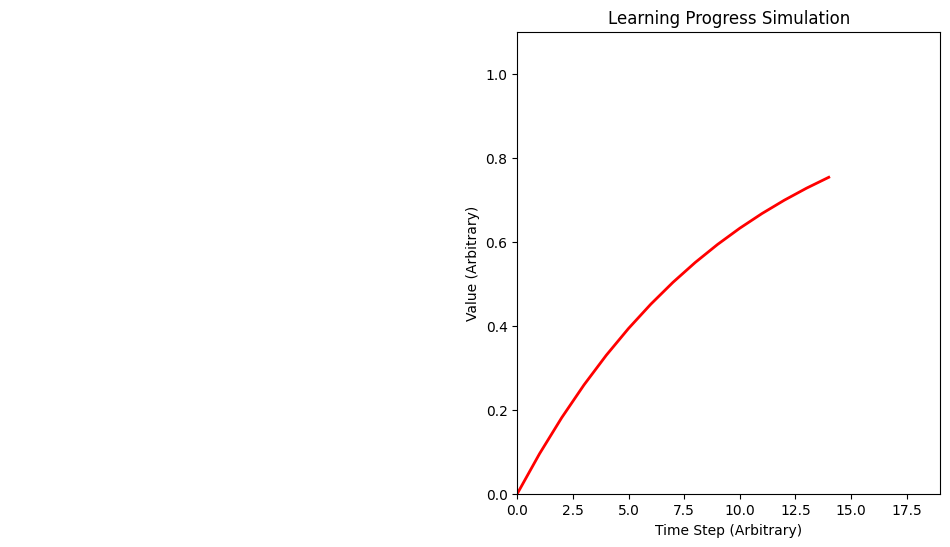

In [ ]:
choice = "Generate Visual Video" #@param ["Generate Text Video", "Generate Visual Video"]

if not all_document_chunks:
    print("No document chunks available for video generation. Please run previous steps.")
else:
    if choice == "Generate Text Video":
        print("\n--- Generating Text Video ---")
        combined_segments = all_document_chunks
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')
        text_display = ax.text(5, 5, "", ha='center', va='center', wrap=True, fontsize=12)

        def update_text_video(frame):
            if frame < len(combined_segments):
                segment = combined_segments[frame]
                wrapped_text = "\n".join(textwrap.wrap(segment, width=60))
                text_display.set_text(wrapped_text)
            else:
                text_display.set_text("")
            return text_display,

        ani = animation.FuncAnimation(fig, update_text_video, frames=len(combined_segments) + 10, blit=True, interval=3000, repeat=False)
        try:
            print("\nSaving animated text video. This may take a while...")
            ani.save('animated_text_concept.mp4', writer='ffmpeg', fps=1)
            print("Animation saved as animated_text_concept.mp4")
        except Exception as e:
            print(f"Error saving animation: {e}")
            print("Saving video requires ffmpeg. Please ensure it's installed.")

    elif choice == "Generate Visual Video":
        print("\n--- Generating Visual Video ---")
        combined_segments = all_document_chunks
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.set_xlim(0, 10)
        ax1.set_ylim(0, 10)
        ax1.axis('off')
        text_display = ax1.text(5, 5, "", ha='center', va='center', wrap=True, fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5))

        ax2.set_xlabel("Time Step (Arbitrary)")
        ax2.set_ylabel("Value (Arbitrary)")
        ax2.set_title("Learning Progress Simulation")
        ax2.set_xlim(0, len(combined_segments))
        ax2.set_ylim(0, 1.1)
        line, = ax2.plot([], [], 'r-', lw=2)
        xdata, ydata = [], []

        def update_visual_video(frame):
            if frame < len(combined_segments):
                segment = combined_segments[frame]
                wrapped_text = "\n".join(textwrap.wrap(segment, width=50))
                text_display.set_text(wrapped_text)
            else:
                text_display.set_text("")

            if frame < len(combined_segments):
                xdata.append(frame)
                simulated_progress = 1 - np.exp(-0.1 * frame)
                ydata.append(simulated_progress)
                line.set_data(xdata, ydata)
                ax2.set_xlim(0, max(1, frame + 5))
                ax2.set_ylim(0, max(1.1, max(ydata) * 1.1 if ydata else 0.1))
            return text_display, line

        ani = animation.FuncAnimation(fig, update_visual_video, frames=len(combined_segments) + 10, blit=True, interval=3000, repeat=False)
        try:
            print("\nSaving animated visual video. This may take a while...")
            ani.save('learning_animation.mp4', writer='ffmpeg', fps=1)
            print("Animation saved as learning_animation.mp4")
        except Exception as e:
            print(f"Error saving animation: {e}")
            print("Saving video requires ffmpeg. Please ensure it's installed.")
    else:
        print("Invalid choice for video generation.")

# Table: Summary of Failure Cases and Proposed Enhancements

| **Failure Case**                        | **Description**                                                                                | **Proposed Enhancement**                                                                                    |
| --------------------------------------- | ---------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **1. Tabular Data Loss**                | OCR-flattened tables lost semantic structure, lowering retrieval recall.                       | Use table-aware extractors (e.g., Camelot, Tabula) and chunk tables as single units.                        |
| **2. Cross-Source Reasoning Failure**   | System could not relate information across documents (e.g., audio vs. PDF).                    | Add metadata tags (e.g., `"source": "audio"`) and enable source-aware prompts.                              |
| **3. Abstract Query Underperformance**  | Vague or underspecified questions led to mediocre retrieval and weak answers.                  | Use query rewriting, HyDE, or clarification prompts for sub-question generation.                            |
| **4. Embedding Limitations**            | Current model struggled with ambiguous or domain-specific semantics.                           | Use advanced embeddings (e.g., BGE, E5) or ensemble hybrid retrieval.                                       |
| **5. Lack of Domain Adaptation**        | Generic LLM missed context-specific logic, syntax, or jargon.                                  | Apply domain-specific fine-tuning (LoRA/QLoRA) or prompt tuning.                                            |
| **6. Limited Visual Semantics via OCR** | OCR fails to retain meaning from diagrams or rich pictorial representations.                   | Incorporate Intelligent Character Recognition (ICR) or Vision-Language Models (e.g., Donut, Pix2Struct).    |
| **7. Lack of Multimodal Understanding** | Performing arts or literary subjects with nuanced visual/audio content are poorly represented. | Integrate video understanding models (e.g., Flamingo, VideoCLIP) and cross-modal retrieval.                 |
| **8. Basic Multimedia Generation**      | Video/audio outputs are simplistic; limited support for learning diversity.                    | Enable video shorts, TTS/audio snippet generation, and multimodal responses to aid neurodivergent learners. |
